# Preprocessing Stage

In [17]:
import cv2
import math
import numpy as np
import skimage.io as io
from skimage.filters import  sobel_v
import matplotlib.pyplot as plt

def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [106]:
# This function is used to convert an RGB image to a grayscale image using the formula: Y = 0.299R + 0.587G + 0.114B
def rgb2gray(img):
    R = img[:,:,0] # Red channel
    G = img[:,:,1] # Green channel
    B = img[:,:,2] # Blue channel
    gray_img = np.zeros_like(img) # Create a blank image with the same size as the original image
    gray_img = 0.299 * R + 0.587 * G + 0.114 * B # Convert the image to grayscale
    return gray_img

img = io.imread("imgs/img.png")
img = cv2.resize(img, (704, 576))
gray_img = rgb2gray(img)


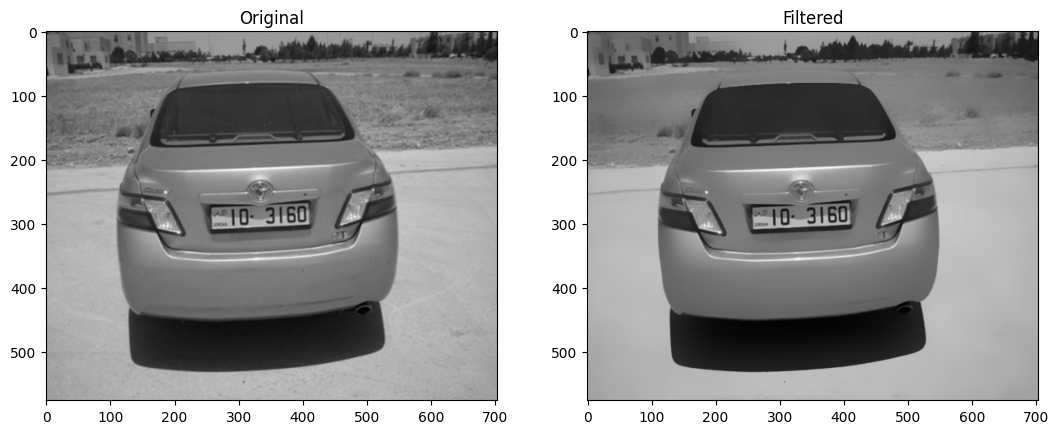

In [107]:
def gaussian(x_square, sigma):
    return np.exp(-0.5 * x_square / sigma ** 2)

# Bilateral filter function
def bilateral_filter(image, sigma_space, sigma_intensity):
    image = image.astype(float)
    # kernel_size should be twice the sigma space to avoid calculating negligible values
    kernel_size = int(2 * sigma_space + 1)
    # Calculate half of the kernel size
    half_kernel_size = kernel_size // 2
    # Initialize the result image with zeros
    result = np.zeros_like(image)
    # Initialize the normalization factor
    W = 0

    # Iterating over the kernel
    for x in range(-half_kernel_size, half_kernel_size + 1):
        for y in range(-half_kernel_size, half_kernel_size + 1):
            # Calculate the spatial Gaussian component
            Gspace = gaussian(x ** 2 + y ** 2, sigma_space)
            # Shift the image by (x, y)
            shifted_image = np.roll(image, [x, y], [1, 0])
            # Calculate the intensity difference
            intensity_difference_image = image - shifted_image
            # Calculate the intensity Gaussian component
            Gintenisity = gaussian(intensity_difference_image ** 2, sigma_intensity)
            # Update the result image
            result += Gspace * Gintenisity * shifted_image
            # Update the normalization factor
            W += Gspace * Gintenisity

    # Normalize the result image
    return result / W

# Apply the bilateral filter
filtered_image = bilateral_filter(gray_img, 17, 17)
show_images([gray_img, filtered_image], ["Original", "Filtered"])

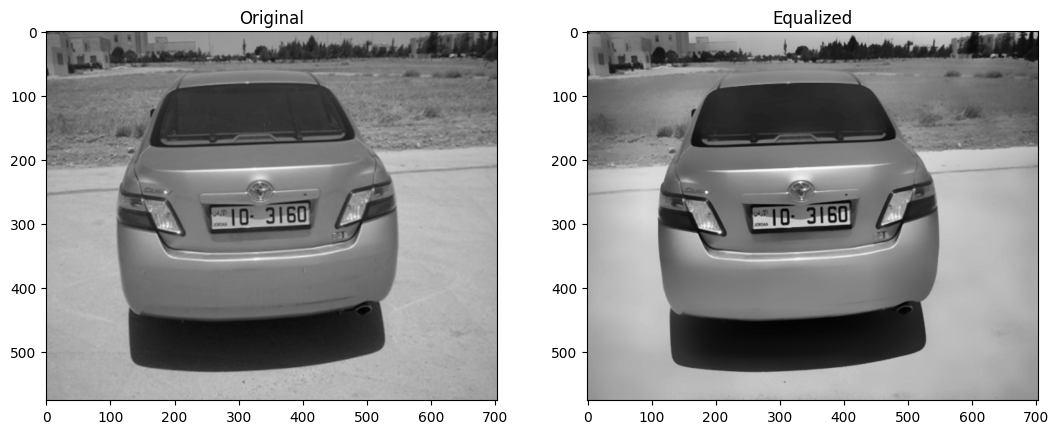

In [108]:
def CLAHE(image, clip_limit=0.005, grid_size=(8, 8)):
    image = image.astype(float)
    rows, cols = image.shape

    # Number of grid tiles in rows and cols
    grid_rows, grid_cols = grid_size
    tile_height = rows // grid_rows
    tile_width = cols // grid_cols

    # Initialize output image
    equalized_image = np.zeros_like(image)

    # Compute histograms and apply CLAHE for each tile
    histograms = []
    for i in range(grid_rows):
        row_histograms = []
        for j in range(grid_cols):
            # Tile boundaries
            start_row = i * tile_height
            end_row = start_row + tile_height if i < grid_rows - 1 else rows
            start_col = j * tile_width
            end_col = start_col + tile_width if j < grid_cols - 1 else cols

            # Extract tile
            tile = image[start_row:end_row, start_col:end_col]

            # Compute histogram and clip it
            hist, _ = np.histogram(tile.flatten(), bins=256, range=(0, 256))
            if clip_limit > 0:
                clip_value = clip_limit * tile.size
                excess = np.maximum(hist - clip_value, 0).sum()
                hist = np.minimum(hist, clip_value)
                # Redistribute excess pixels
                hist += excess // 256

            # Compute cumulative distribution function (CDF)
            cdf = hist.cumsum()
            cdf_normalized = np.clip((cdf / cdf[-1]) * 255, 0, 255)  # Normalize to [0, 255]

            # Save the CDF for this tile
            row_histograms.append(cdf_normalized)
        histograms.append(row_histograms)

    # Apply bilinear interpolation for smooth transitions between tiles
    for i in range(rows):
        for j in range(cols):
            # Determine tile indices
            tile_i = min(i // tile_height, grid_rows - 1)
            tile_j = min(j // tile_width, grid_cols - 1)

            # Get neighboring tiles
            i1 = max(tile_i, 0)
            j1 = max(tile_j, 0)
            i2 = min(tile_i + 1, grid_rows - 1)
            j2 = min(tile_j + 1, grid_cols - 1)

            # Compute relative position inside the tile
            row_ratio = (i - tile_i * tile_height) / tile_height
            col_ratio = (j - tile_j * tile_width) / tile_width

            # Retrieve CDF values
            cdf_11 = histograms[i1][j1]
            cdf_12 = histograms[i1][j2]
            cdf_21 = histograms[i2][j1]
            cdf_22 = histograms[i2][j2]

            # Perform bilinear interpolation
            value = image[i, j]
            interpolated_value = (
                (1 - row_ratio) * (1 - col_ratio) * cdf_11[int(value)]
                + (1 - row_ratio) * col_ratio * cdf_12[int(value)]
                + row_ratio * (1 - col_ratio) * cdf_21[int(value)]
                + row_ratio * col_ratio * cdf_22[int(value)]
            )
            equalized_image[i, j] = interpolated_value

    return equalized_image


# Apply CLAHE to the filtered image
equalized_image = CLAHE(filtered_image)
show_images([gray_img, equalized_image], ["Original", "Equalized"])

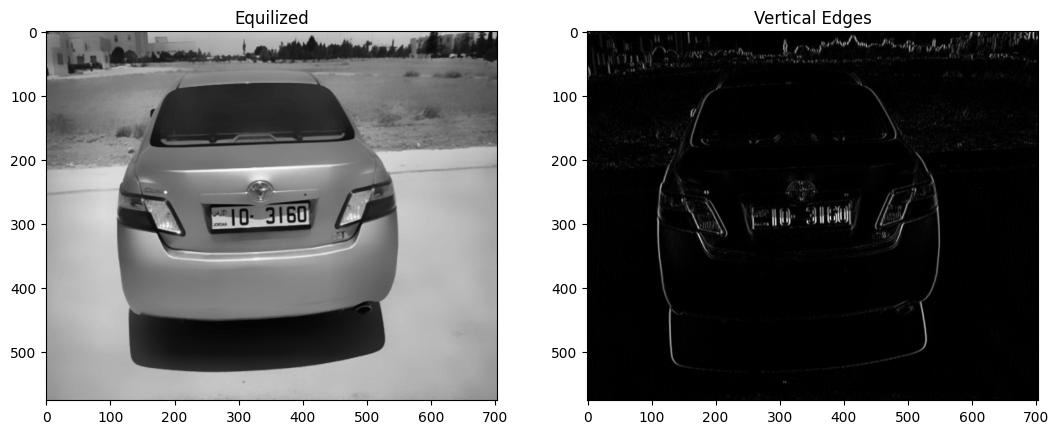

In [109]:
# Detect vertical edges using Sobel filter
vertical_edges = np.abs(sobel_v(equalized_image))

show_images([equalized_image, vertical_edges], ["Equilized", "Vertical Edges"])

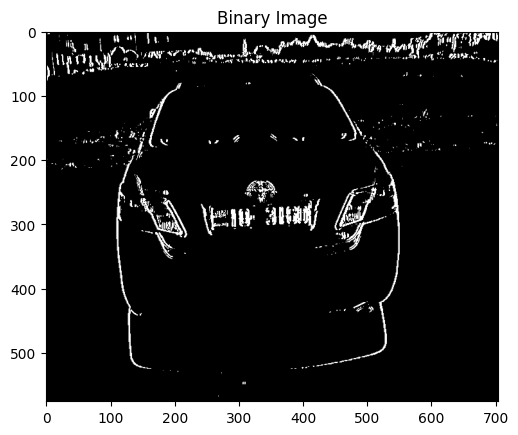

In [110]:
def image_binarization(vertical_edges):
    # Calculate the threshold based on mean and standard deviation
    img_mean = np.mean(vertical_edges[vertical_edges != 0])
    thresh = img_mean + 3.5 * img_mean

    # Initialize variables
    binary_image = np.zeros_like(vertical_edges)
    prev_x, prev_y = None, None

    # Iterate through pixels
    for y in range(vertical_edges.shape[0]):
        for x in range(vertical_edges.shape[1]):
            if vertical_edges[y, x] > thresh:
                if prev_x is None and prev_y is None:  # First edge pixel
                    prev_x, prev_y = x, y
                    binary_image[y, x] = 1
                else:
                    # Compute distance to previous edge pixel
                    dist = math.sqrt((prev_x - x) ** 2 + (prev_y - y) ** 2)
                    if dist < 15:
                        binary_image[y, x] = 1
                    else:
                        binary_image[y, x] = 0.5

                    # Update previous coordinates
                    prev_x, prev_y = x, y
            else:
                binary_image[y, x] = 0

    return binary_image


# Binarize the vertical edges image
binary_image = image_binarization(vertical_edges)
show_images([binary_image], ["Binary Image"])

# PROCESSING

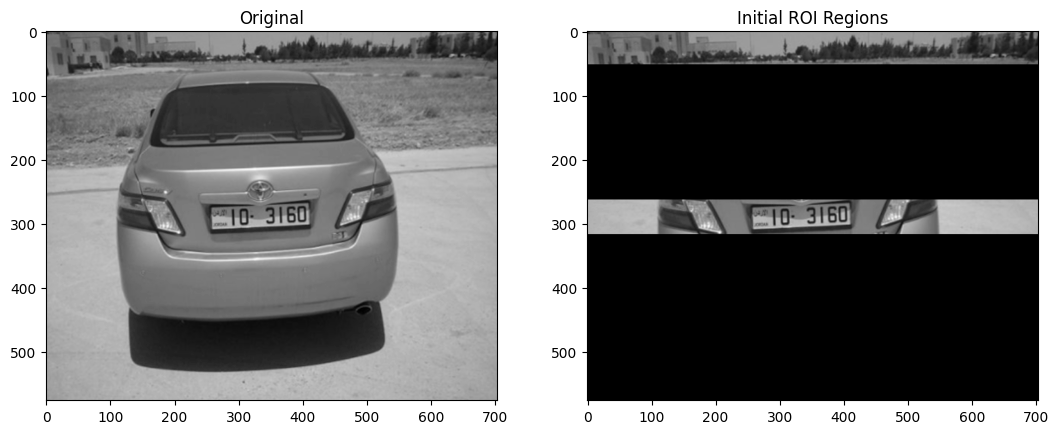

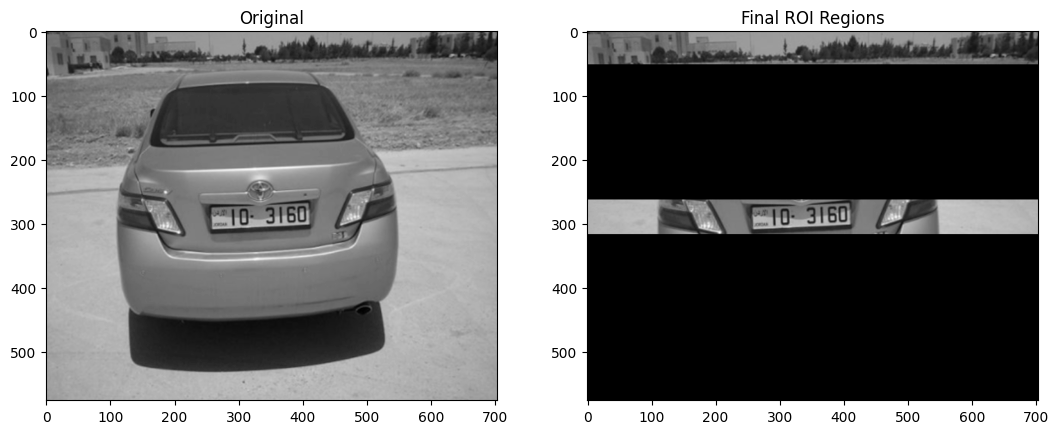

In [111]:
def initial_roi_region(weighted_edges, gray_img):
        
        # Threshold rows depending on edges variance
        row_var = np.var(weighted_edges, axis=1)
        thresh = max(row_var)/3
        roi_img = np.zeros(weighted_edges.shape)
        roi_img[row_var>thresh, :] = gray_img[row_var>thresh, :]

        # Get ROI regions and then filter them
        roi_sum = np.sum(roi_img, axis=1)
        roi_start = 0
        roi_end = 0
        roi_regions = []

        inRegion = False
        for i in range(len(roi_sum)):
            if roi_sum[i] != 0 and inRegion == False:
                if len(roi_regions) != 0 and i-roi_regions[-1][1] < 10:
                    roi_start,_ = roi_regions.pop()
                else:
                    roi_start = i
                inRegion = True
            if roi_sum[i] == 0 and inRegion == True:
                roi_end = i-1
                inRegion = False
                
                if roi_end - roi_start >15:
                    roi_regions.append([roi_start, roi_end])

        
        if len(roi_regions) == 0 or roi_regions[-1][0] != roi_start:
            roi_regions.append([roi_start,roi_end])

        filtered_regions = []
        for region in roi_regions:
            if region[1] - region[0] > 10 and region[1] - region[0] < gray_img.shape[0]/3:
                filtered_regions.append(region)
        
        return filtered_regions


filtered_roi_regions = initial_roi_region(binary_image, gray_img)

# show before filtering ROI regions
roi_img = np.zeros_like(gray_img)
for region in filtered_roi_regions:
    roi_img[region[0]:region[1], :] = gray_img[region[0]:region[1], :]
show_images([gray_img, roi_img], ["Original", "Initial ROI Regions"])

# mask the image with the ROI regions
# Filter and merge ROI regions
final_roi_regions = []
for region in filtered_roi_regions:
    height = region[1] - region[0]
    if  height <= gray_img.shape[0] / 4.5:
        if final_roi_regions and region[0] - final_roi_regions[-1][1] < 15:
            final_roi_regions[-1][1] = region[1]
        else:
            final_roi_regions.append(region)

# Mask the image with the final ROI regions
roi_img = np.zeros_like(gray_img)
for region in final_roi_regions:
    roi_img[region[0]:region[1], :] = gray_img[region[0]:region[1], :]
show_images([gray_img, roi_img], ["Original", "Final ROI Regions"])

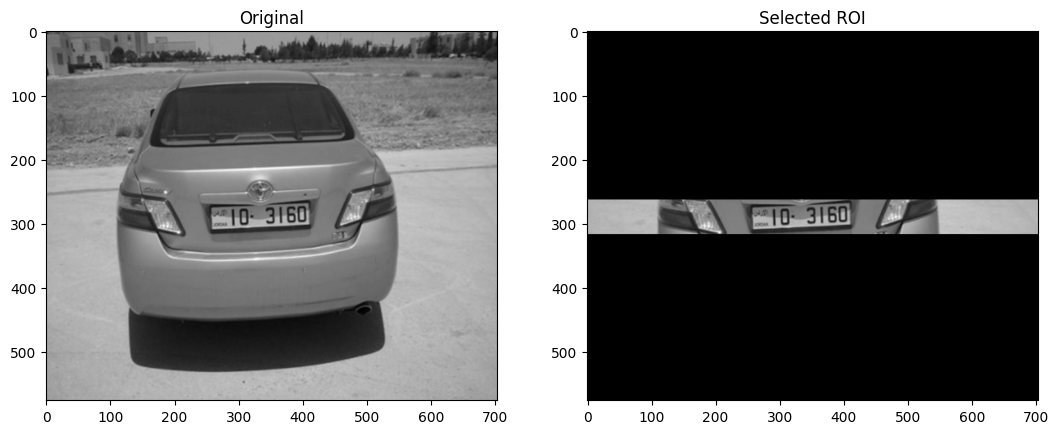

In [ ]:
def update_edge_power(vertical_edges, roi_regions):
    power_edges = np.zeros_like(vertical_edges)
    max_power = 0
    max_power_row = 0

    for region in roi_regions:
        start_row, end_row = region
        for y in range(start_row, end_row + 1):
            for x in range(vertical_edges.shape[1]):
                if vertical_edges[y, x] > 0:
                    # Rule 1: Edges not in the extreme left or right get higher power
                    if x > vertical_edges.shape[1] * 0.1 and x < vertical_edges.shape[1] * 0.9:
                        power_edges[y, x] += 2
                    else:
                        power_edges[y, x] += 1

                    # Rule 2: Edges with the same height and occurrence distance less than 25 get maximum power
                    for prev_x in range(max(0, x - 25), min(vertical_edges.shape[1], x + 25)):
                        if vertical_edges[y, prev_x] > 0 and abs(prev_x - x) < 25:
                            power_edges[y, x] += 3

                    # Rule 3: Increase edge power from top to bottom
                    power_edges[y, x] += (y - start_row) / (end_row - start_row + 1)

    return power_edges

def select_roi_candidate(power_edges, roi_regions):
    max_power = 0
    selected_roi = None

    for region in roi_regions:
        start_row, end_row = region
        region_power = np.sum(power_edges[start_row:end_row + 1, :])
        if region_power > max_power:
            max_power = region_power
            selected_roi = region

    return selected_roi

# Update edge power
power_edges = update_edge_power(vertical_edges, final_roi_regions)

# Select the ROI candidate with the maximum edge power
selected_roi = select_roi_candidate(power_edges, final_roi_regions)

# Visualize the selected ROI
roi_img = np.zeros_like(gray_img)
if selected_roi:
    start_row, end_row = selected_roi
    roi_img[start_row:end_row, :] = gray_img[start_row:end_row, :]

show_images([gray_img, roi_img], ["Original", "Selected ROI"])

# make the image the size of the selected ROI
if selected_roi:
    start_row, end_row = selected_roi
    roi_img = gray_img[start_row:end_row, :]
    show_images([roi_img], ["Selected ROI"])

Left: -39456.81913568781, Right: 40144.262193452174
